In [ ]:
!pip install wordcloud

In [ ]:
import nltk

import warnings
import pandas as pd
import numpy as np
import seaborn as sns

from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re, string, matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer

sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

In [ ]:
# import San Franscisco reviews datasets
reviews_url = 'https://data.insideairbnb.com/united-states/ca/san-francisco/2025-09-01/data/reviews.csv.gz'
calendar_url = 'https://data.insideairbnb.com/united-states/ca/san-francisco/2025-09-01/data/calendar.csv.gz'
listings_url = 'https://data.insideairbnb.com/united-states/ca/san-francisco/2025-09-01/data/listings.csv.gz'

In [ ]:
# Load the datasets into DataFrames
reviews_df = pd.read_csv(reviews_url, compression='gzip')
calendar_df = pd.read_csv(calendar_url, compression='gzip')
listings_df = pd.read_csv(listings_url, compression='gzip')

# **Listings Dataset:**

In [ ]:
# Display dataset shape and sample rows
print("Dataset shape:", listings_df.shape)
display(listings_df.head())

Dataset shape: (7780, 79)


id                        listing_url       scrape_id last_scraped  \
0   958   https://www.airbnb.com/rooms/958  20250901181253   2025-09-01   
1  5858  https://www.airbnb.com/rooms/5858  20250901181253   2025-09-01   
2  8014  https://www.airbnb.com/rooms/8014  20250901181253   2025-09-01   
3  8142  https://www.airbnb.com/rooms/8142  20250901181253   2025-09-01   
4  8339  https://www.airbnb.com/rooms/8339  20250901181253   2025-09-01   

        source                                               name  \
0  city scrape              Bright, Modern Garden Unit - 1BR/1BTH   
1  city scrape                                 Creative Sanctuary   
2  city scrape     female HOST quiet fast internet market parking   
3  city scrape  *FriendlyRoom Apt. Style -UCSF/USF - San Franc...   
4  city scrape                    Historic Alamo Square Victorian   

                                         description  \
0  Our bright garden unit overlooks a lovely back...   
1  We live in a large Victorian house on a quiet ...   
2  Room is on the second floor so it gets a good ...   
3  Nice and good public transportation.  7 minute...   
4  For creative humans who love art, space, photo...   

                               neighborhood_overview  \
0  Quiet cul de sac in friendly neighborhood<br /...   
1  I love how our neighborhood feels quiet but is...   
2  The neighborhood is very residential, close to...   
3  N Juda Muni, Bus and UCSF Shuttle.<br /><br />...   
4                                                NaN   

                                         picture_url  host_id  ...  \
0  https://a0.muscache.com/pictures/be1bf5ac-a955...     1169  ...   
1  https://a0.muscache.com/pictures/hosting/Hosti...     8904  ...   
2  https://a0.muscache.com/pictures/2cc1fc3d-0ae0...    22402  ...   
3  https://a0.muscache.com/pictures/hosting/Hosti...    21994  ...   
4  https://a0.muscache.com/pictures/miso/Hosting-...    24215  ...   

  review_scores_communication review_scores_location review_scores_value  \
0                        4.89                   4.98                4.78   
1                        4.85                   4.77                4.68   
2                        4.94                   4.59                4.66   
3                        4.80                   4.70                4.70   
4                        5.00                   4.94                4.75   

       license instant_bookable calculated_host_listings_count  \
0  STR-0006854                f                              1   
1          NaN                f                              1   
2  STR-0000974                f                              3   
3          NaN                f                             20   
4  STR-0000264                f                              1   

  calculated_host_listings_count_entire_homes  \
0                                           1   
1                                           1   
2                                           0   
3                                           0   
4                                           1   

  calculated_host_listings_count_private_rooms  \
0                                            0   
1                                            0   
2                                            3   
3                                           20   
4                                            0   

  calculated_host_listings_count_shared_rooms reviews_per_month  
0                                           0              2.53  
1                                           0              0.53  
2                                           0              0.57  
3                                           0              0.07  
4                                           0              0.13  

[5 rows x 79 columns]

In [ ]:
# Data type summary
print("\nData types summary:")
display(listings_df.dtypes.value_counts())


Data types summary:


object     35
float64    24
int64      20
Name: count, dtype: int64

In [ ]:
# Count missing values
print("\nColumns with missing values:")
missing = listings_df.isna().sum()
missing_percent = (missing[missing > 0] / len(listings_df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing[missing > 0],
                           'Percent Missing': missing_percent}).sort_values(by='Percent Missing', ascending=False)
display(missing_df)


Columns with missing values:


Missing Values  Percent Missing
neighbourhood_group_cleansed            7780       100.000000
calendar_updated                        7780       100.000000
neighborhood_overview                   3097        39.807198
neighbourhood                           3097        39.807198
host_about                              3084        39.640103
license                                 2647        34.023136
price                                   1985        25.514139
estimated_revenue_l365d                 1985        25.514139
beds                                    1958        25.167095
bathrooms                               1934        24.858612
review_scores_checkin                   1871        24.048843
review_scores_location                  1871        24.048843
review_scores_value                     1871        24.048843
reviews_per_month                       1870        24.035990
first_review                            1870        24.035990
last_review                             1870        24.035990
review_scores_accuracy                  1870        24.035990
review_scores_cleanliness               1870        24.035990
review_scores_communication             1870        24.035990
review_scores_rating                    1870        24.035990
host_location                           1863        23.946015
host_response_rate                      1153        14.820051
host_response_time                      1153        14.820051
host_acceptance_rate                     809        10.398458
bedrooms                                 489         6.285347
host_neighbourhood                       336         4.318766
has_availability                         256         3.290488
host_is_superhost                        137         1.760925
description                               92         1.182519
bathrooms_text                            51         0.655527
maximum_minimum_nights                    10         0.128535
maximum_maximum_nights                    10         0.128535
minimum_maximum_nights                    10         0.128535
minimum_minimum_nights                    10         0.128535
host_name                                  1         0.012853
host_thumbnail_url                         1         0.012853
host_since                                 1         0.012853
host_total_listings_count                  1         0.012853
host_verifications                         1         0.012853
host_has_profile_pic                       1         0.012853
host_identity_verified                     1         0.012853
host_listings_count                        1         0.012853
host_picture_url                           1         0.012853

We can identify key variables like price, host_since, availability_*, and review_scores_* that need type conversion and cleaning.

Some columns (URLs, image links) can be dropped before modeling.

## **Data Cleaning:**

Drop low-information columns. These columns provide little analytical value:

 * neighbourhood_group_cleansed and calendar_updated is empty for all records
 * listing_url is a link identifier, not useful for analysis.
 * removing them reduces clutter and improves performance.

In [ ]:
# Drop low-info columns
cleansed_listings = listings_df.drop(columns=['neighbourhood_group_cleansed', 'calendar_updated', 'listing_url'], errors='ignore')

## **Replace Missing Host Details with "Unknown":**

In [ ]:
print("Host ID with Hostname as null")
print(cleansed_listings[cleansed_listings['host_name'].isna()][['host_id']])

Host ID with Hostname as null
      host_id
518  17120264


In [ ]:
# fill it with Unknown and drop later
cols_to_fill_unknown = [
    'host_name', 'host_thumbnail_url', 'host_since', 'host_total_listings_count',
    'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
    'host_listings_count', 'host_picture_url'
]

cleansed_listings[cols_to_fill_unknown] = cleansed_listings[cols_to_fill_unknown].fillna('Unknown')

## **Drop rows where price (target variable) is missing:**

Since price will be the target variable for prediction, we don’t impute it as doing so could distort model accuracy. We instead remove listings with missing prices and convert all valid values to numeric format for modeling.

In [ ]:
cleansed_listings = cleansed_listings.dropna(subset=['price'])
cleansed_listings['price'] = cleansed_listings['price'].replace(r'[\$,]', '', regex=True).astype(float)

## **Convert date columns to datetime format:**

In [ ]:
date_cols = ['last_scraped', 'host_since', 'first_review', 'last_review', 'calendar_last_scraped']
cleansed_listings[date_cols] = cleansed_listings[date_cols].apply(pd.to_datetime, errors='coerce')

## **Fill high-missing text columns with "Not provided":**

These textual description fields are optional for hosts and frequently empty.
Filling them with "Not provided" retains the structure of the dataset and makes it clear that information was omitted by the host.

In [ ]:
# High-missing text columns → fill "Not provided"
text_cols = ['neighborhood_overview', 'neighbourhood', 'host_about', 'license']
cleansed_listings[text_cols] = cleansed_listings[text_cols].fillna('Not provided')

## **Impute missing numeric values with median:**

Median imputation is used for numeric data to prevent outliers from skewing results.
This approach keeps distribution patterns realistic and avoids losing records with partial information.

In [ ]:
# Numeric columns (key metrics) → fill median
num_cols = ['estimated_revenue_l365d', 'beds', 'bathrooms', 'bedrooms',
            'minimum_minimum_nights', 'minimum_maximum_nights', 'maximum_minimum_nights', 'maximum_maximum_nights']
for col in num_cols:
    cleansed_listings[col].fillna(cleansed_listings[col].median(), inplace=True)

## **Fill review-related columns with 0:**

Missing review values typically mean no reviews yet.
Filling with 0 preserves interpretability — “no reviews” instead of “unknown” and ensures numerical stability in modeling.

In [ ]:
# Review-related → fill 0 (no reviews)
review_cols = [col for col in cleansed_listings.columns if 'review_scores' in col or 'reviews_per' in col]
cleansed_listings[review_cols] = cleansed_listings[review_cols].fillna(0)

## **Fill host meta-fields with "Unknown":**

In [ ]:
# Host fields → fill "Unknown"
host_cols = ['host_location', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_neighbourhood']
cleansed_listings[host_cols] = cleansed_listings[host_cols].fillna('Unknown')

## **Fill descriptive text and bathroom details:**

In [ ]:
# Description / bathrooms_text → fill "Not specified"
cleansed_listings[['description', 'bathrooms_text']] = cleansed_listings[['description', 'bathrooms_text']].fillna('Not specified')

## **Fix missing has_availability logically:**

If has_availability is missing, it can be inferred from the detailed calendar fields.
This maintains logical consistency — listings with zero available days are correctly marked as unavailable.

In [ ]:
def fill_has_availability(row):
    if pd.isna(row['has_availability']):
        if row['availability_30'] == 0 and row['availability_60'] == 0 and row['availability_90'] == 0 and row['availability_365'] == 0:
            return 'f'  # No availability
        else:
            return 't'  # Some availability
    else:
        return row['has_availability']

cleansed_listings['has_availability'] = cleansed_listings.apply(fill_has_availability, axis=1)

## **Fill missing host_is_superhost with most common value:**

The Superhost status is a categorical flag; filling missing values with the mode (most common) avoids NaNs while keeping distribution realistic.

In [ ]:
cleansed_listings['host_is_superhost'] = cleansed_listings['host_is_superhost'].fillna(cleansed_listings['host_is_superhost'].mode()[0])

## **Check remaining missing values:**

This final audit confirms that all significant gaps have been handled.

In [ ]:
missing = cleansed_listings.isna().sum()
missing_percent = (missing[missing > 0] / len(cleansed_listings)) * 100
missing_df = pd.DataFrame({'Missing Values': missing[missing > 0],
                           'Percent Missing': missing_percent}).sort_values(by='Percent Missing', ascending=False)
display(missing_df)

Missing Values  Percent Missing
first_review            1153        19.896462
last_review             1153        19.896462
host_since                 1         0.017256

## **Correlation Matrix:**

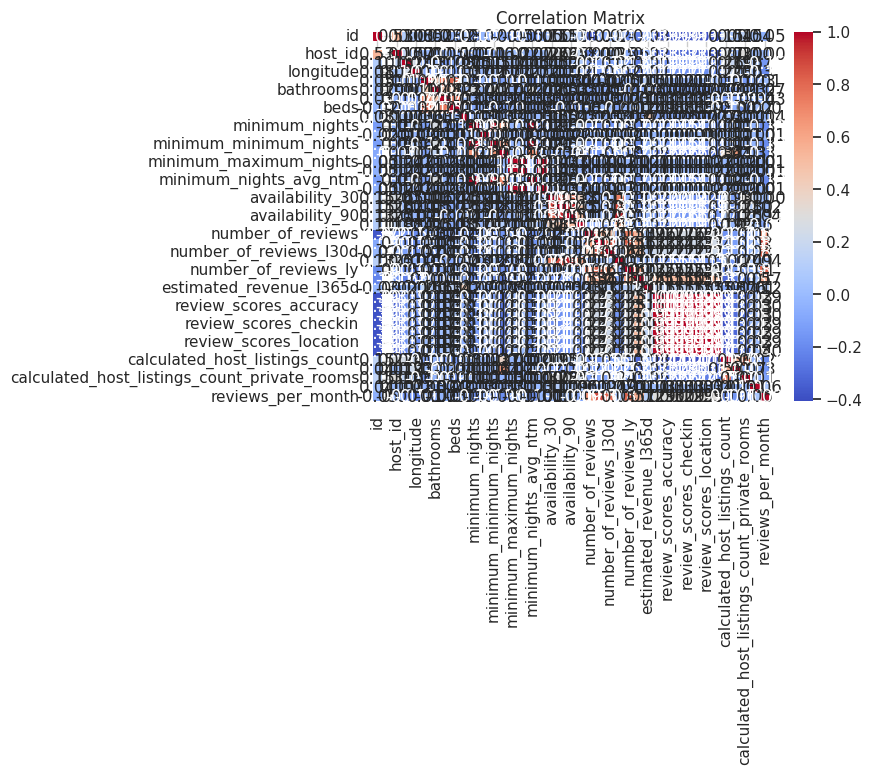

In [ ]:
correlationmatrix = cleansed_listings.select_dtypes(include=['int64', 'float64'])
corr = correlationmatrix.corr()

# Full correlation heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

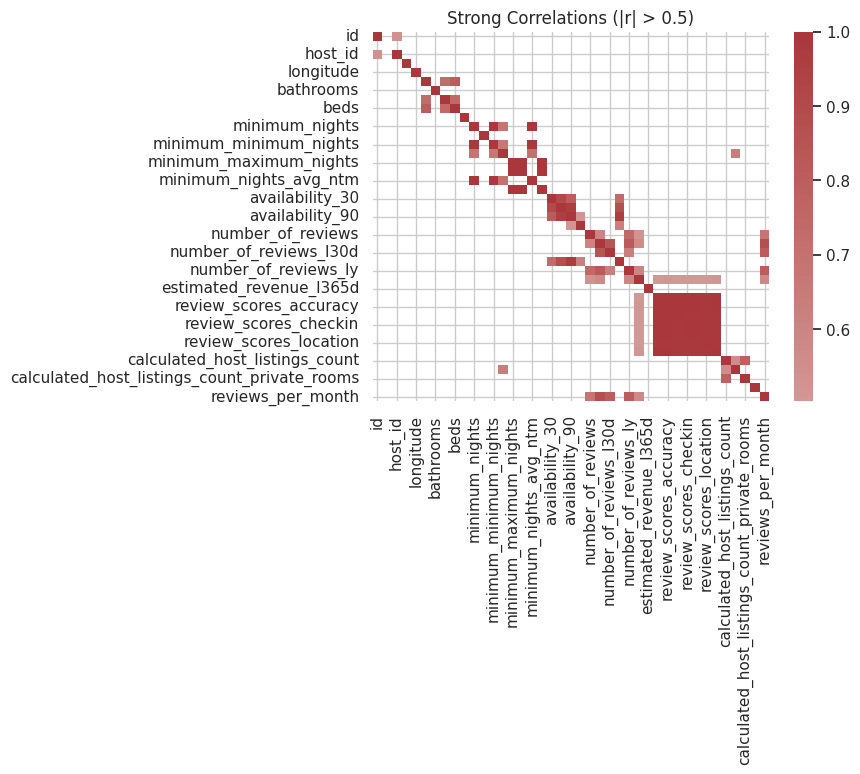

In [ ]:
# Highlight only strong correlations (|r| > 0.5)

strong_corr = corr[(corr > 0.5) | (corr < -0.5)]
sns.heatmap(strong_corr, cmap='vlag', center=0)
plt.title("Strong Correlations (|r| > 0.5)")
plt.show()

In [ ]:
# Create a tidy correlation table (for reporting)
corr_table = (
    corr.unstack()
    .reset_index()
    .rename(columns={'level_0': 'Feature 1', 'level_1': 'Feature 2', 0: 'Correlation'})
)

# Remove self-correlations and duplicate pairs
corr_table = corr_table[corr_table['Feature 1'] < corr_table['Feature 2']]

# Keep only strong correlations
corr_table = corr_table[abs(corr_table['Correlation']) > 0.5]

# Sort by strength for interpretability
corr_table = corr_table.sort_values(by='Correlation', ascending=False).reset_index(drop=True)

corr_table

Feature 1                    Feature 2  Correlation
0      maximum_maximum_nights       maximum_nights_avg_ntm     1.000000
1      maximum_nights_avg_ntm       minimum_maximum_nights     1.000000
2      maximum_maximum_nights       minimum_maximum_nights     1.000000
3      review_scores_accuracy         review_scores_rating     0.995101
4              minimum_nights       minimum_nights_avg_ntm     0.994592
..                        ...                          ...          ...
60  estimated_occupancy_l365d         review_scores_rating     0.507916
61  estimated_occupancy_l365d  review_scores_communication     0.507909
62  estimated_occupancy_l365d    review_scores_cleanliness     0.507667
63  estimated_occupancy_l365d        review_scores_checkin     0.503987
64  estimated_occupancy_l365d       review_scores_location     0.502540

[65 rows x 3 columns]

## **Night Variables Are Redundant → Keep minimum_nights**

maximum_maximum_nights, minimum_maximum_nights, minimum_minimum_nights, minimum_nights_avg_ntm all correlate ~1 with minimum_nights. Keep a single representative.

In [ ]:
# Inspect the night-rule correlations quickly (optional)
night_cols = ['minimum_nights','minimum_minimum_nights','minimum_maximum_nights', 'maximum_minimum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm']
night_corr = cleansed_listings[night_cols].corr()

In [ ]:
# Keep only minimum_nights; drop the rest if present
drop_night_cols = list(set(night_cols) - {'minimum_nights'})
cleansed_listings = cleansed_listings.drop(columns=[c for c in drop_night_cols if c in cleansed_listings.columns])

## **Review Score Subscales Are Similar → Keep review_scores_rating**

All review_scores_* are ~0.99 with each other and with review_scores_rating. Use the given rating or an average fallback.




In [ ]:
score_cols = ['review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location']
# Optionally drop the individual subscales to reduce redundancy
cleansed_listings = cleansed_listings.drop(columns=[c for c in score_cols])

In [ ]:
listings_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

# **Exploratory Data Analysis**


## **Visualize and Clean Price Outliers:**

The long tail of very high-priced listings can skew the mean and distort relationships.

Trimming the top 1% keeps the analysis focused on typical Airbnb listings (majority behavior).

After removal, the distribution becomes more symmetrical and model-ready.

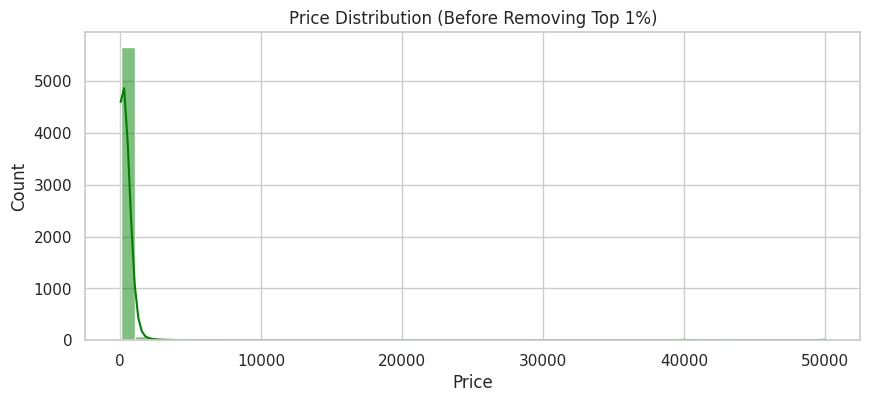

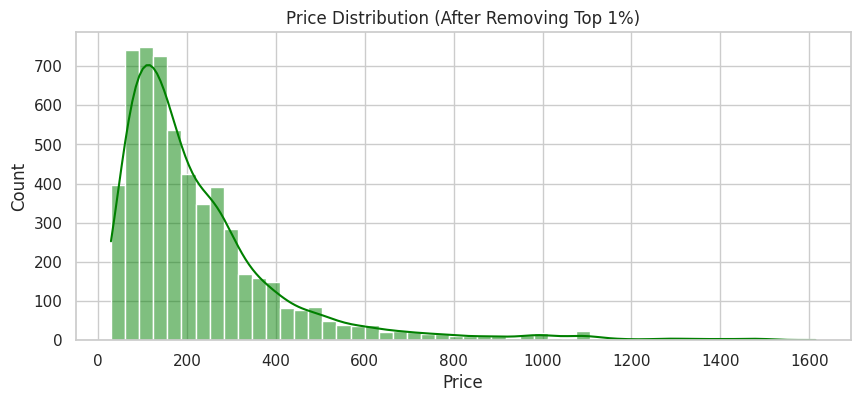

In [ ]:
# Visualize the original price distribution
plt.figure(figsize=(10, 4))
sns.histplot(cleansed_listings['price'], bins=50, kde=True, color='green')
plt.title("Price Distribution (Before Removing Top 1%)")
plt.xlabel("Price")
plt.show()

# Remove top 1% of extreme price values
price_cap = cleansed_listings['price'].quantile(0.99)
cleansed_listings = cleansed_listings[cleansed_listings['price'] <= price_cap]

# Visualize the cleaned price distribution
plt.figure(figsize=(10, 4))
sns.histplot(cleansed_listings['price'], bins=50, kde=True, color='green')
plt.title("Price Distribution (After Removing Top 1%)")
plt.xlabel("Price")
plt.show()

## **Average Price by Neighbourhood:**

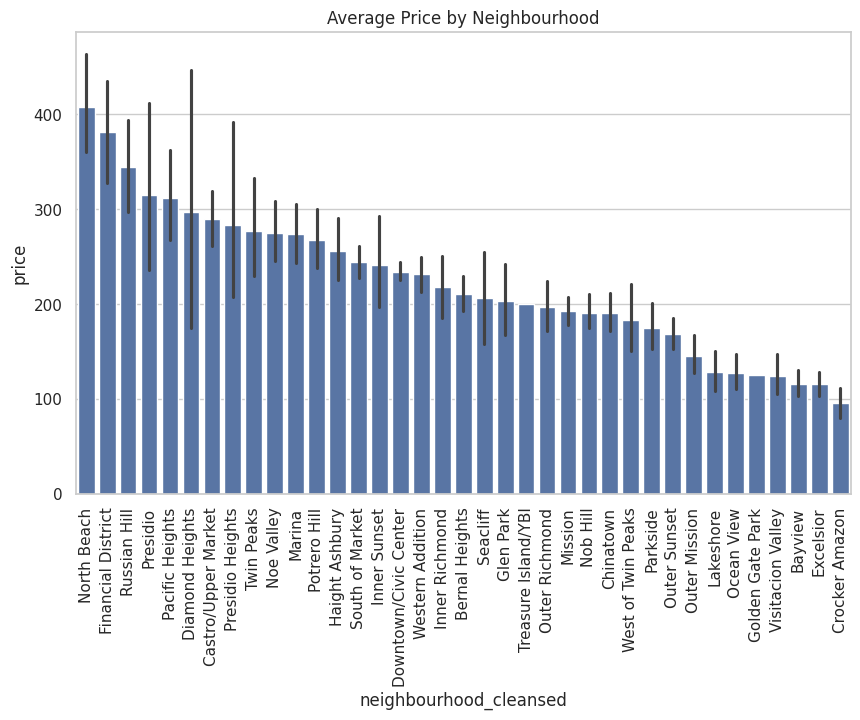

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x='neighbourhood_cleansed', y='price', data=cleansed_listings, estimator=np.mean, order=cleansed_listings.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False).index)
plt.xticks(rotation=90)
plt.title("Average Price by Neighbourhood")
plt.show()

## **Average Price by Property Type:**

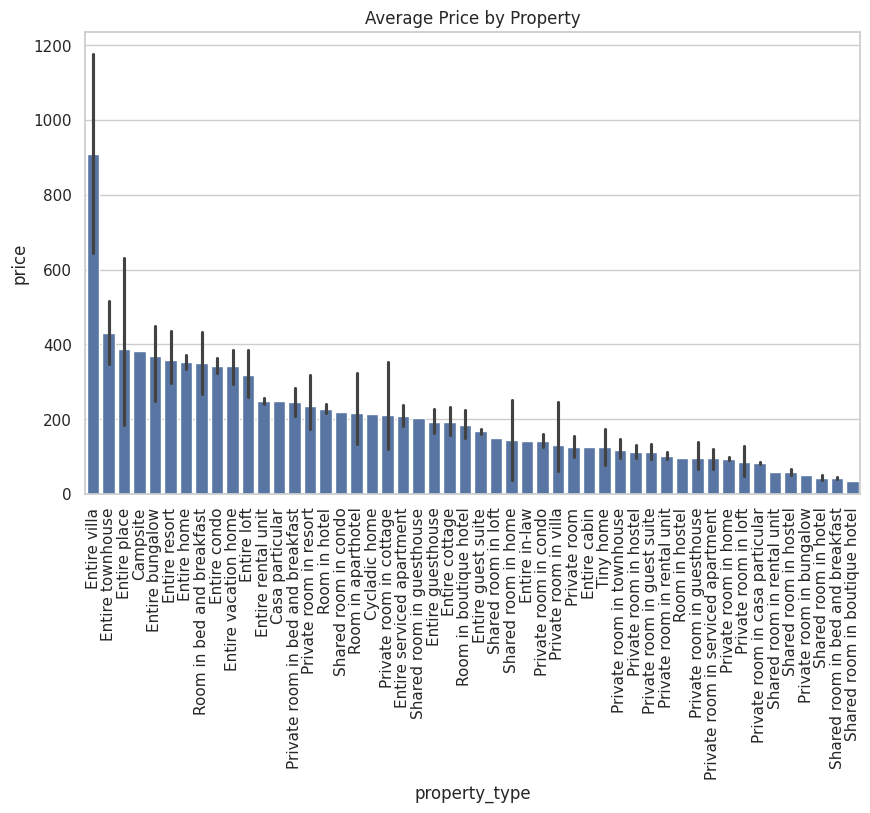

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x='property_type', y='price', data=cleansed_listings, estimator=np.mean, order=cleansed_listings.groupby('property_type')['price'].mean().sort_values(ascending=False).index)
plt.xticks(rotation=90)
plt.title("Average Price by Property")
plt.show()

## **Number of Guests Accommodated vs Price:**

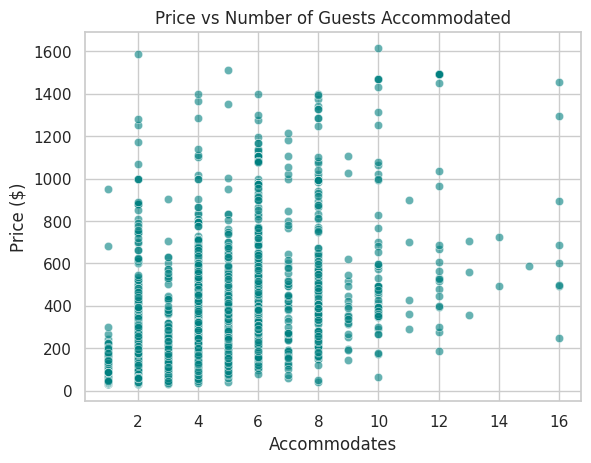

In [ ]:
sns.scatterplot(x='accommodates', y='price', data=cleansed_listings, alpha=0.6, color='teal')
plt.title("Price vs Number of Guests Accommodated")
plt.xlabel("Accommodates")
plt.ylabel("Price ($)")
plt.show()

## **Superhost Status vs Price:**

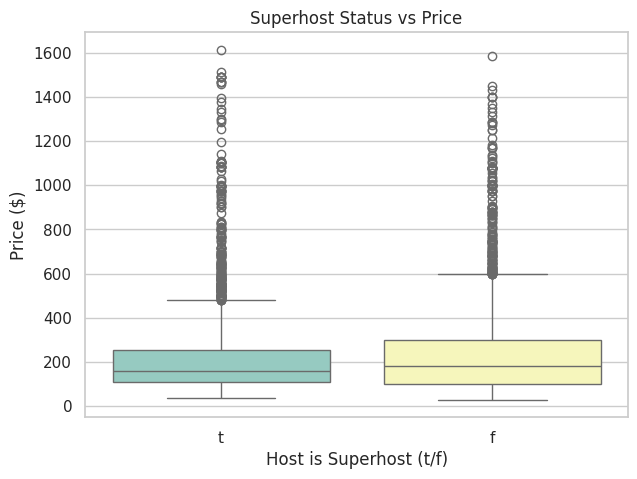

In [ ]:
plt.figure(figsize=(7,5))
sns.boxplot(x='host_is_superhost', y='price', data=cleansed_listings, palette='Set3')
plt.title("Superhost Status vs Price")
plt.xlabel("Host is Superhost (t/f)")
plt.ylabel("Price ($)")
plt.show()

## **Amenities count vs Price:**

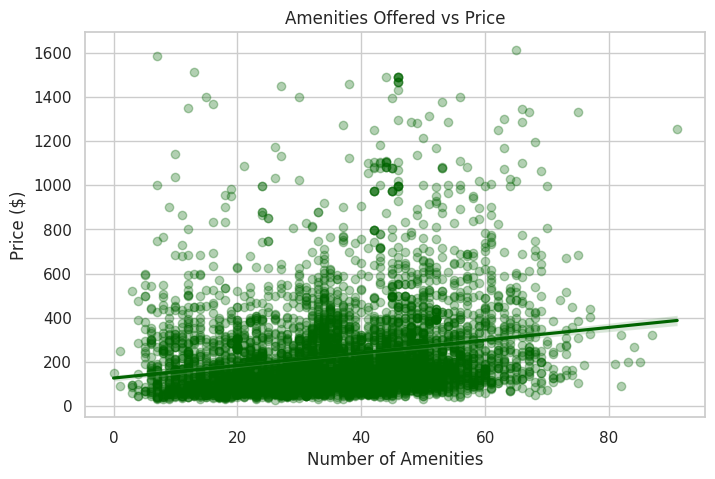

In [ ]:
cleansed_listings['amenity_count'] = cleansed_listings['amenities'].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)

plt.figure(figsize=(8,5))
sns.regplot(x='amenity_count', y='price', data=cleansed_listings, scatter_kws={'alpha':0.3}, color='darkgreen')
plt.title("Amenities Offered vs Price")
plt.xlabel("Number of Amenities")
plt.ylabel("Price ($)")
plt.show()

## **Occupancy Rate vs Price:**

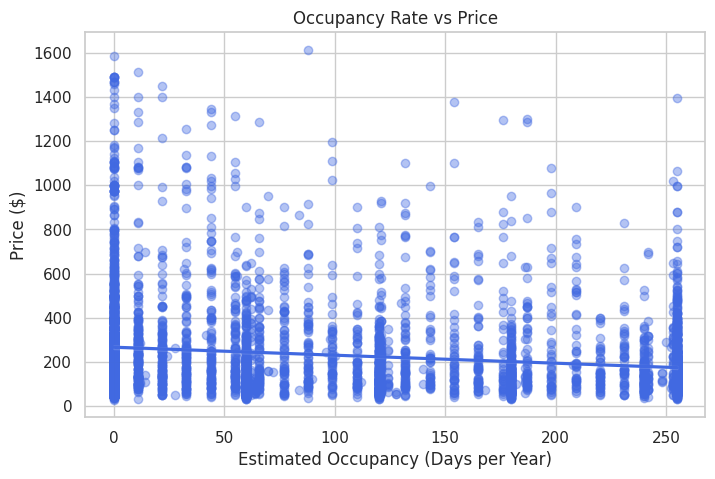

In [ ]:
plt.figure(figsize=(8,5))
sns.regplot(
    x='estimated_occupancy_l365d', y='price',
    data=cleansed_listings, scatter_kws={'alpha':0.4}, color='royalblue'
)
plt.title("Occupancy Rate vs Price")
plt.xlabel("Estimated Occupancy (Days per Year)")
plt.ylabel("Price ($)")
plt.show()

## **Host Tenure vs Price:**
Tests if experienced hosts charge more.

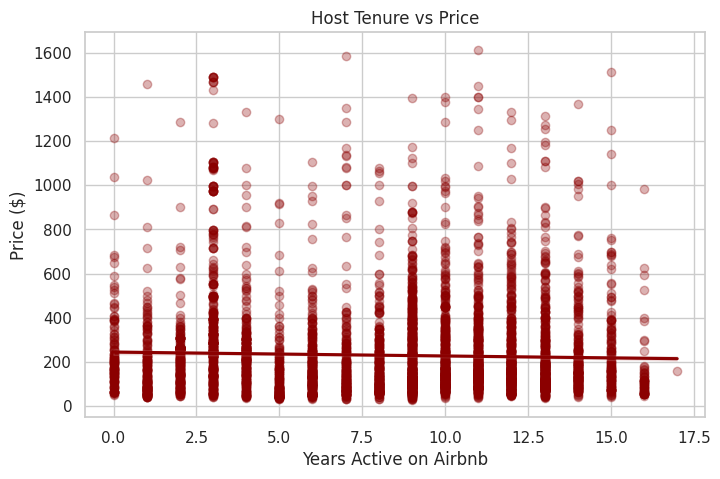

In [ ]:
cleansed_listings['host_years_active'] = (pd.Timestamp.now().year - cleansed_listings['host_since'].dt.year)

plt.figure(figsize=(8,5))
sns.regplot(x='host_years_active', y='price', data=cleansed_listings, scatter_kws={'alpha':0.3}, color='darkred')
plt.title("Host Tenure vs Price")
plt.xlabel("Years Active on Airbnb")
plt.ylabel("Price ($)")
plt.show()

## **Annual Availability Distribution of Listings:**
Reveals how booked or free listings typically are.

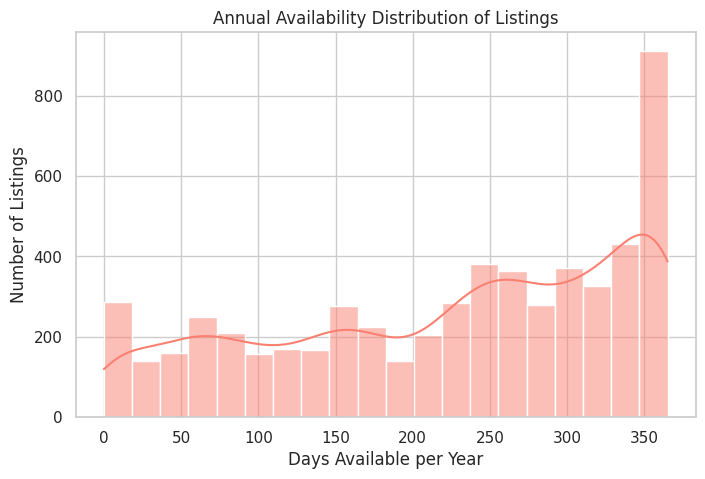

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(cleansed_listings['availability_365'], bins=20, kde=True, color='salmon')
plt.title("Annual Availability Distribution of Listings")
plt.xlabel("Days Available per Year")
plt.ylabel("Number of Listings")
plt.show()

## **Geographical Distribution of Listings by Price:**

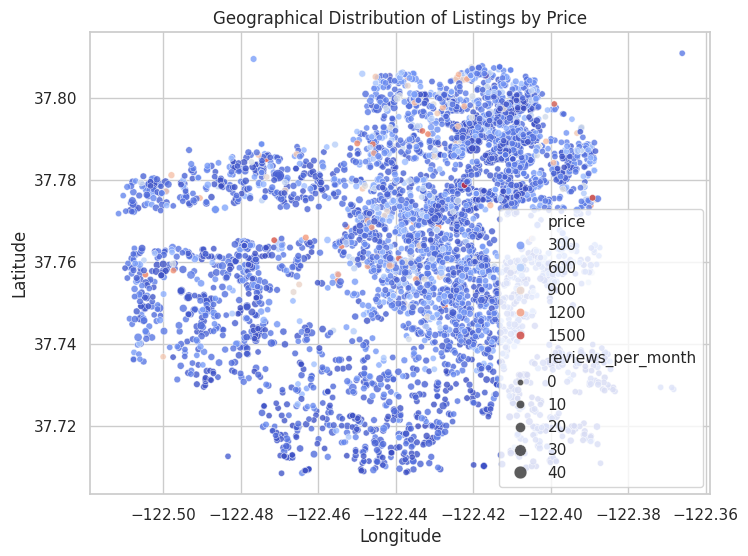

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='longitude', y='latitude', data=cleansed_listings,
    hue='price', size='reviews_per_month', sizes=(20,100),
    palette='coolwarm', alpha=0.8
)
plt.title("Geographical Distribution of Listings by Price")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## **Review Frequency vs Price:**

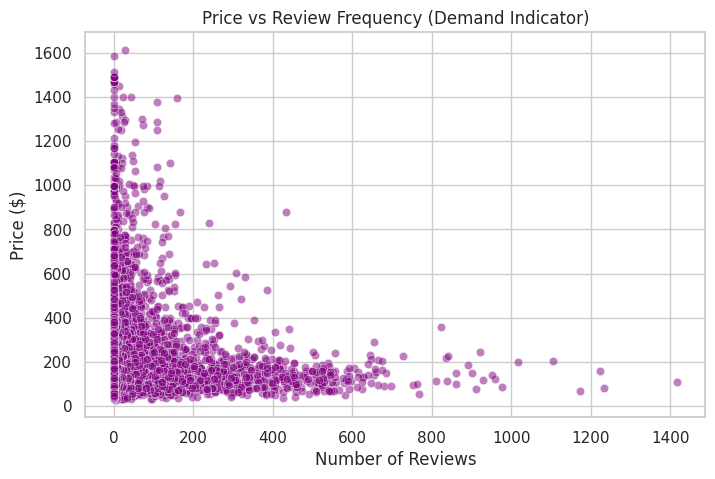

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='number_of_reviews', y='price', data=cleansed_listings, alpha=0.5, color='purple')
plt.title("Price vs Review Frequency (Demand Indicator)")
plt.xlabel("Number of Reviews")
plt.ylabel("Price ($)")
plt.show()

## **Relationship between Bathrooms and Price:**

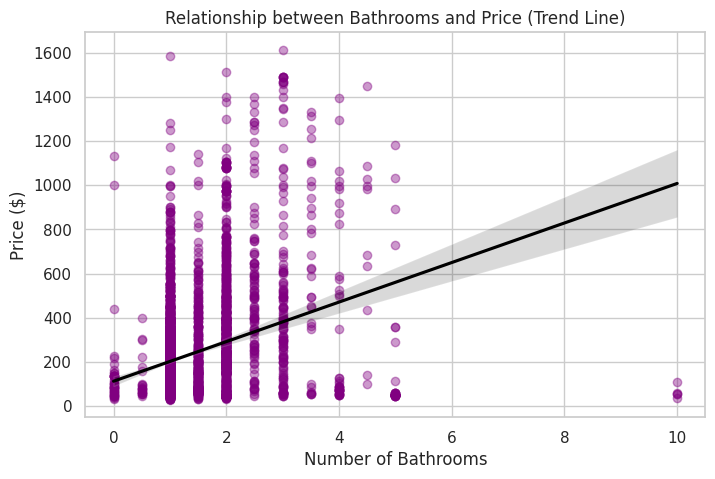

In [ ]:
plt.figure(figsize=(8,5))
sns.regplot(
    x='bathrooms', y='price', data=cleansed_listings,
    scatter_kws={'alpha':0.4, 'color':'purple'},
    line_kws={'color':'black'}
)
plt.title("Relationship between Bathrooms and Price (Trend Line)")
plt.xlabel("Number of Bathrooms")
plt.ylabel("Price ($)")
plt.show()

## **Relationship between Bedrooms and Price:**

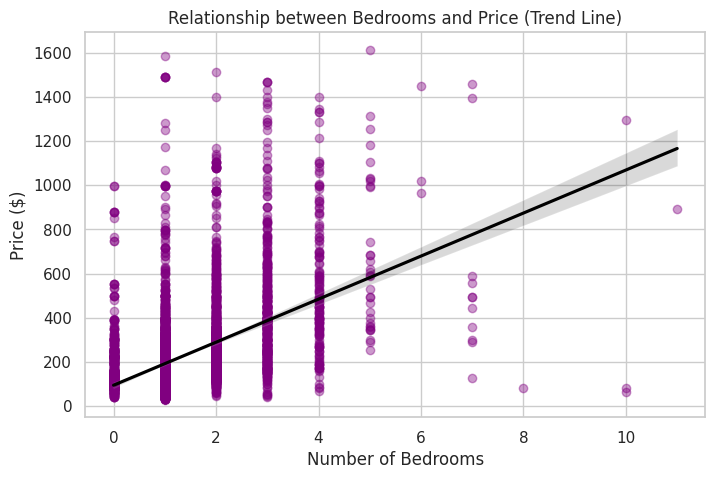

In [ ]:
plt.figure(figsize=(8,5))
sns.regplot(
    x='bedrooms', y='price', data=cleansed_listings,
    scatter_kws={'alpha':0.4, 'color':'purple'},
    line_kws={'color':'black'}
)
plt.title("Relationship between Bedrooms and Price (Trend Line)")
plt.xlabel("Number of Bedrooms")
plt.ylabel("Price ($)")
plt.show()

## **Relationship between Beds and Price:**

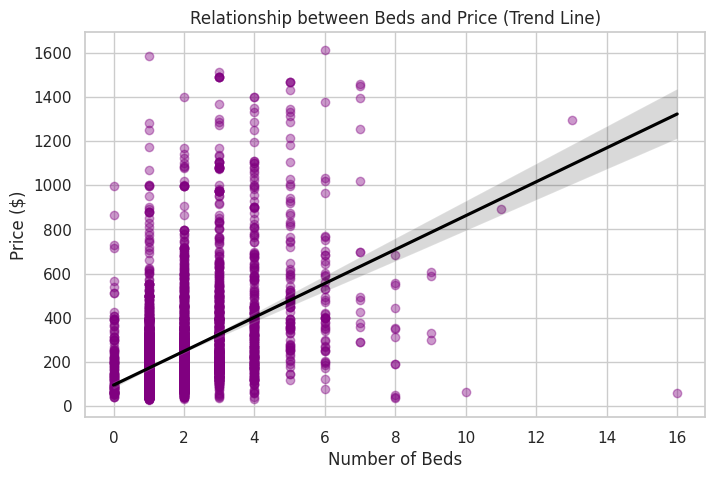

In [ ]:
plt.figure(figsize=(8,5))
sns.regplot(
    x='beds', y='price', data=cleansed_listings,
    scatter_kws={'alpha':0.4, 'color':'purple'},
    line_kws={'color':'black'}
)
plt.title("Relationship between Beds and Price (Trend Line)")
plt.xlabel("Number of Beds")
plt.ylabel("Price ($)")
plt.show()

# **Reviews Dataset**

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')         # tokenizer support
nltk.download('wordnet')      # lemmatizer support
nltk.download('omw-1.4')      # optional, for lemmatization dictionary

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410017 entries, 0 to 410016
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     410017 non-null  int64 
 1   id             410017 non-null  int64 
 2   date           410017 non-null  object
 3   reviewer_id    410017 non-null  int64 
 4   reviewer_name  410016 non-null  object
 5   comments       409943 non-null  object
dtypes: int64(3), object(3)
memory usage: 18.8+ MB


In [ ]:
reviews_df.shape

(410017, 6)

In [ ]:
reviews_df.head()

listing_id     id        date  reviewer_id reviewer_name  \
0         958   5977  2009-07-23        15695      Edmund C   
1         958   6660  2009-08-03        26145         Simon   
2         958  11519  2009-09-27        25839         Denis   
3         958  16282  2009-11-05        33750          Anna   
4         958  26008  2010-02-13        15416     V Jillian   

                                            comments  
0  Our experience was, without a doubt, a five st...  
1  Returning to San Francisco is a rejuvenating t...  
2  We were very pleased with the accommodations a...  
3  We highly recommend this accomodation and agre...  
4  Holly's place was great. It was exactly what I...

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w.isalpha() and w not in stop_words]
    return " ".join(tokens)

In [ ]:
reviews_df['cleaned_reviews'] = reviews_df['comments'].astype(str).apply(clean_text)

## **Reviews per year**

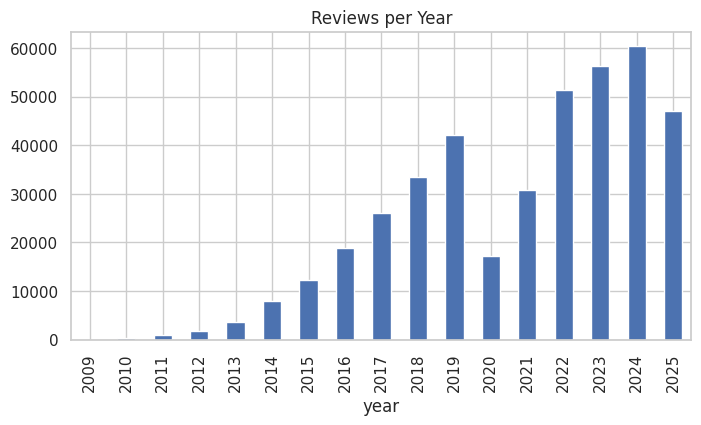

In [ ]:
reviews_df['date'] = pd.to_datetime(reviews_df['date'])
reviews_df['year'] = reviews_df['date'].dt.year
reviews_df['year'].value_counts().sort_index().plot(kind='bar', figsize=(8,4), title='Reviews per Year')
plt.show()

## **Stats**

In [ ]:
reviews_df['length'] = reviews_df['cleaned_reviews'].apply(lambda x: len(x.split()))
reviews_df['length'].describe()

count    410017.000000
mean         24.633418
std          23.159684
min           0.000000
25%           9.000000
50%          18.000000
75%          32.000000
max         484.000000
Name: length, dtype: float64

## **Bigrams and Trigrams**

In [ ]:
ngram_vectorizer = CountVectorizer(ngram_range=(2,3), stop_words='english', max_features=5000)
X_ngrams = ngram_vectorizer.fit_transform(reviews_df['cleaned_reviews'])

In [ ]:
ngrams_df = pd.DataFrame(X_ngrams.toarray(), columns=ngram_vectorizer.get_feature_names_out())
top_ngrams = ngrams_df.sum().sort_values(ascending=False).head(20)

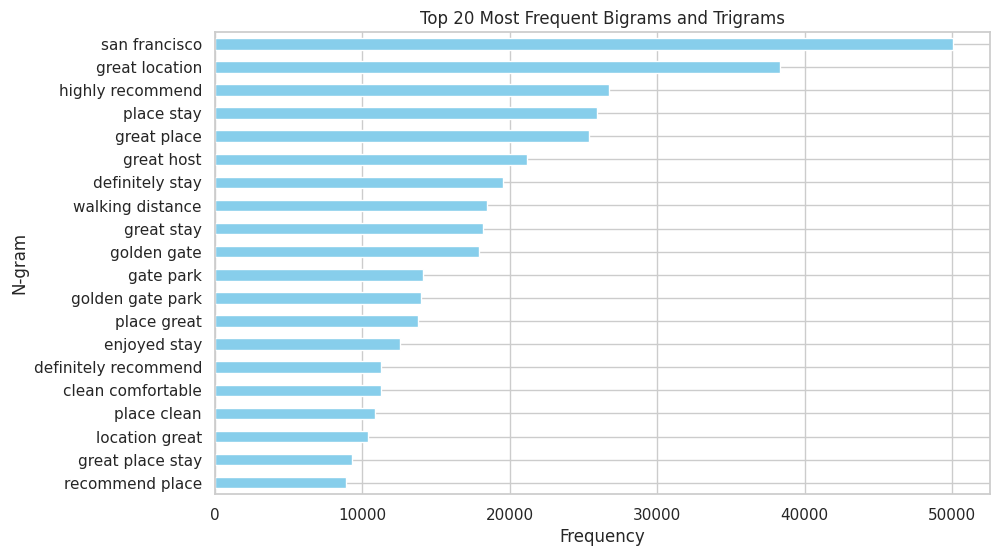

In [ ]:
plt.figure(figsize=(10,6))
top_ngrams.plot(kind='barh', color='skyblue')
plt.title("Top 20 Most Frequent Bigrams and Trigrams")
plt.xlabel("Frequency")
plt.ylabel("N-gram")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=20, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(reviews_df['cleaned_reviews'])

## **Pre-process**:

In [ ]:
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if pd.isnull(text):
        return ''
    # Remove URLs, non-letters, and convert to lowercase
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()

    # Tokenize and remove stopwords - word_tokenize() would be more accurate but slow
    tokens = text.split()
    stop_words = set(stopwords.words('english'))

    # Lemmatize and remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word not in string.punctuation]

    return ' '.join(tokens)

## **Filter Reviews:**

In [ ]:
# Ensure the 'date' column is in datetime format
reviews_df['date'] = pd.to_datetime(reviews_df['date'], errors='coerce')

# Filter only reviews from the year 2019
filtered_reviews = reviews_df[(reviews_df['date'].dt.year == 2019)].copy()
# pre-process comments
filtered_reviews ['cleaned_comments'] = filtered_reviews ['comments'].apply(preprocess_text)

## **Vectorization:**

In [ ]:
# Vectorize the cleaned comments (Bag-of-Words)
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
    min_df=5,
    max_df=0.90,
    stop_words='english',
    #max_features=5000,       # <- keep models fast
    ngram_range=(1, 1)       # <- change to (1, 2) to include bigrams
)

X_bow = vectorizer.fit_transform(filtered_reviews['cleaned_comments'])
feature_names = vectorizer.get_feature_names_out()

print("BoW matrix shape:", X_bow.shape)


BoW matrix shape: (42134, 7157)


In [ ]:
# Vectorize the cleaned comments (TF-IDF)

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    min_df=5,
    max_df=0.90,
    stop_words='english',
    # max_features=5000,
    ngram_range=(1, 1)
)

# This creates the TF-IDF matrix directly
X_tfidf = tfidf_vectorizer.fit_transform(filtered_reviews['cleaned_comments'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

print("TF-IDF matrix shape:", X_tfidf.shape)

TF-IDF matrix shape: (42134, 7157)


## **Plot function:**

In [ ]:
# Function to plot the top words for each topic
def plot_top_words(model, feature_names, n_top_words=10, title='Top words per topic'):
    fig, axes = plt.subplots(1, model.n_components, figsize=(15, 5), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx+1}', fontdict={'fontsize': 10})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=10)
    plt.suptitle(title, fontsize=12)
    plt.subplots_adjust(top=0.85, wspace=0.3)
    plt.show()


# Function to generate word clouds for each topic
def plot_word_clouds(model, feature_names, n_top_words=30):
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = {feature_names[i]: topic[i] for i in top_features_ind}
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_features)
        plt.figure()
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Topic {topic_idx+1} Word Cloud', fontsize=16)
        plt.show()

## **1) Latent Dirichlet Allocation (LDA)**

In [ ]:
# Set the number of topics
n_topics = 7

lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(X_bow)

# Extract the top words from each topic
terms = vectorizer.get_feature_names_out()
lda_topics = {}

for index, topic in enumerate(lda_model.components_):
    top_words = [terms[i] for i in topic.argsort()[-10:][::-1]]  # Get top 10 words and reverse order
    lda_topics[f"Topic {index+1}"] = top_words

# Print the LDA topics
print("LDA Topics:")
for topic, words in lda_topics.items():
    print(f"{topic}: {', '.join(words)}")


LDA Topics:
Topic 1: room, place, great, nice, clean, good, location, bed, park, walk
Topic 2: et, la, trs, le, est, en, bien, pour, nous, muy
Topic 3: great, place, stay, location, clean, host, recommend, nice, comfortable, easy
Topic 4: place, home, stay, great, host, time, location, experience, airbnb, like
Topic 5: und, die, sehr, ist, da, der, wir, war, man, mit


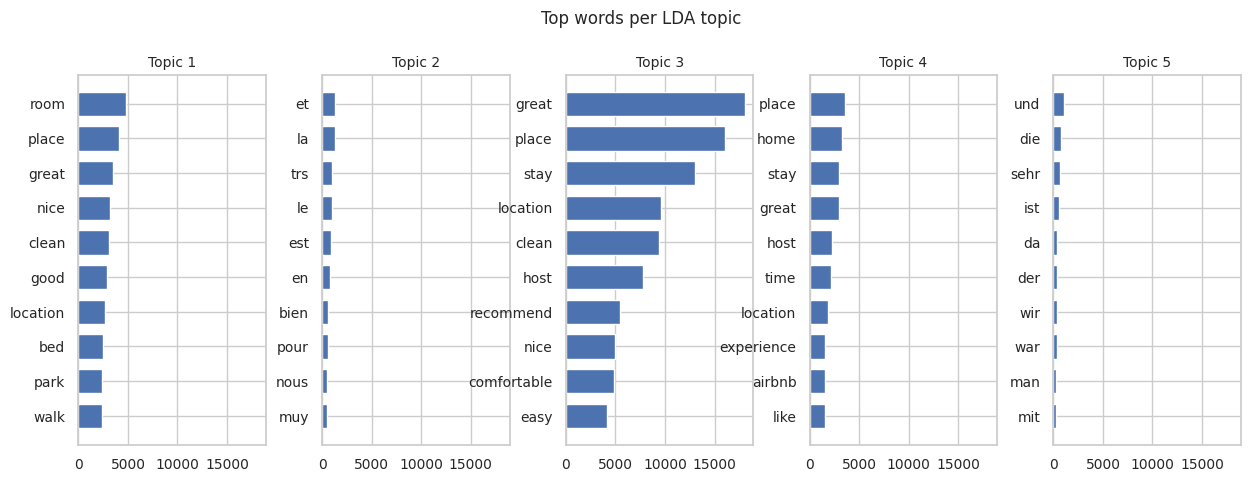

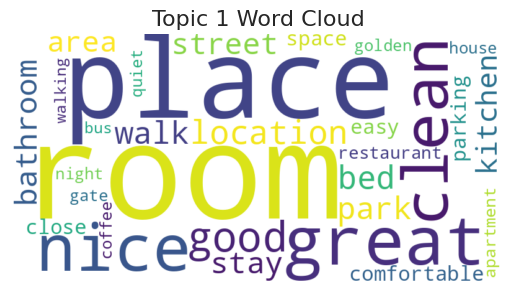

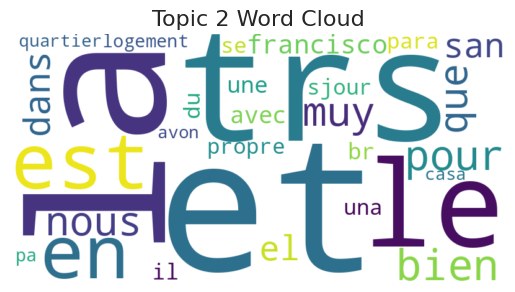

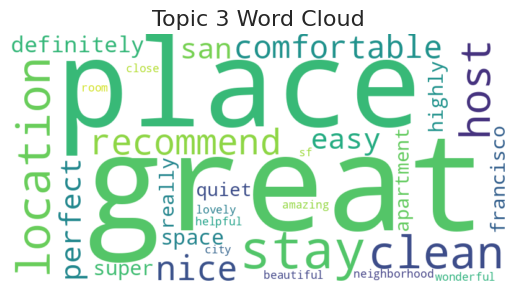

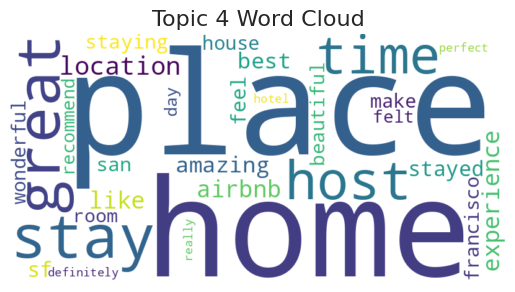

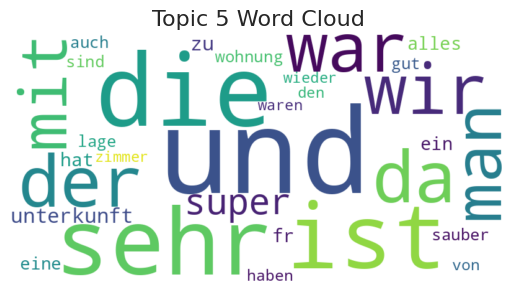

In [ ]:
# LDA topic plots
plot_top_words(lda_model, terms, n_top_words=10, title='Top words per LDA topic')
plot_word_clouds(lda_model, terms)

## **2) Non-negative Matrix Factorization (NMF)**

In [ ]:
nmf_model = NMF(n_components=5, random_state=42)
nmf_model.fit(X_tfidf)

# Extract the top words from each topic
nmf_topics = {}

for index, topic in enumerate(nmf_model.components_):
    top_words = [terms[i] for i in topic.argsort()[-10:][::-1]]  # Get top 10 words and reverse order
    nmf_topics[f"Topic {index+1}"] = top_words

# Print the NMF topics
print("NMF Topics:")
for topic, words in nmf_topics.items():
    print(f"{topic}: {', '.join(words)}")


NMF Topics:
Topic 1: clean, comfortable, easy, room, recommend, space, host, home, beautiful, perfect
Topic 2: great, location, host, value, space, clean, communication, spot, excellent, hospitality
Topic 3: place, stay, great, definitely, amazing, awesome, enjoyed, perfect, recommend, wonderful
Topic 4: nice, clean, place, really, room, host, quiet, location, neighborhood, area
Topic 5: good, location, value, price, clean, room, communication, money, parking, hotel


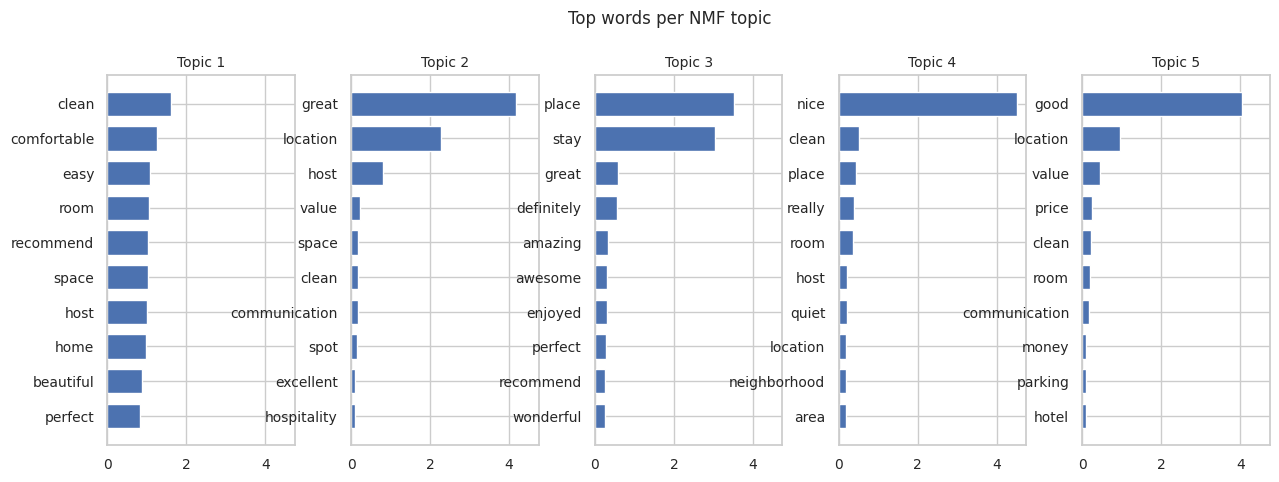

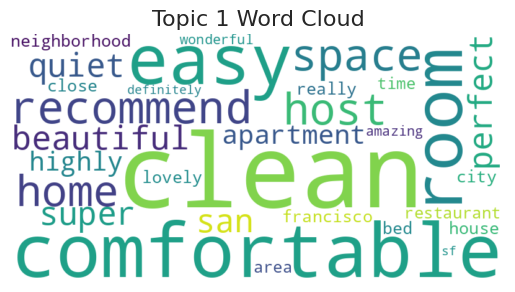

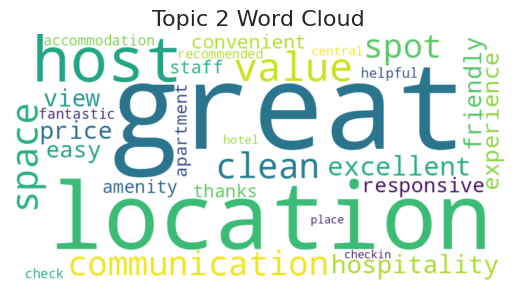

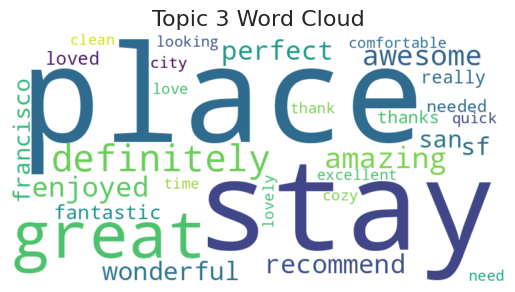

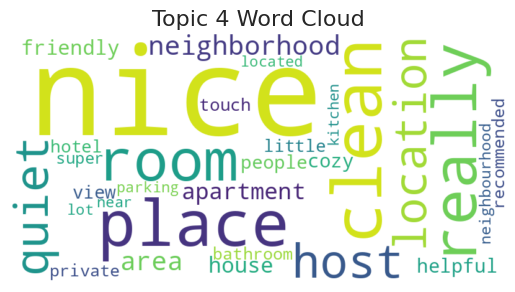

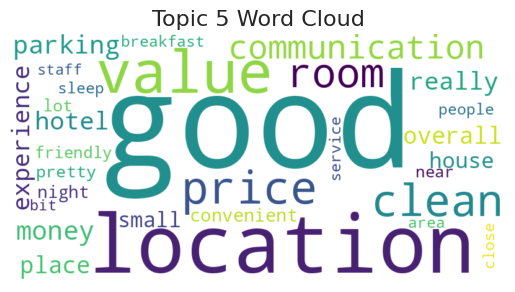

In [ ]:
# NMF topic plots
plot_top_words(nmf_model, terms, n_top_words=10, title='Top words per NMF topic')
plot_word_clouds(nmf_model, terms)

## **3) Latent Semantic Analysis(LSA):**

In [ ]:
lsa_model = TruncatedSVD(n_components=5, random_state=42)
lsa_model.fit(X_bow)

# Extract the top words for each topic
terms = vectorizer.get_feature_names_out()
lsa_topics = {}

for index, topic in enumerate(lsa_model.components_):
    top_words = [terms[i] for i in topic.argsort()[-10:][::-1]]  # Get top 10 words and reverse order
    lsa_topics[f"Topic {index+1}"] = top_words

# Print the LSA topics
print("LSA Topics:")
for topic, words in lsa_topics.items():
    print(f"{topic}: {', '.join(words)}")


LSA Topics:
Topic 1: place, great, stay, location, clean, host, room, nice, comfortable, san
Topic 2: great, location, host, space, communication, value, spot, restaurant, apartment, thanks
Topic 3: place, great, recommend, eat, awesome, kelly, crash, sus, peter, robs
Topic 4: et, le, la, est, trs, san, francisco, nous, pour, en
Topic 5: stay, definitely, san, francisco, enjoyed, home, wonderful, perfect, amazing, loved


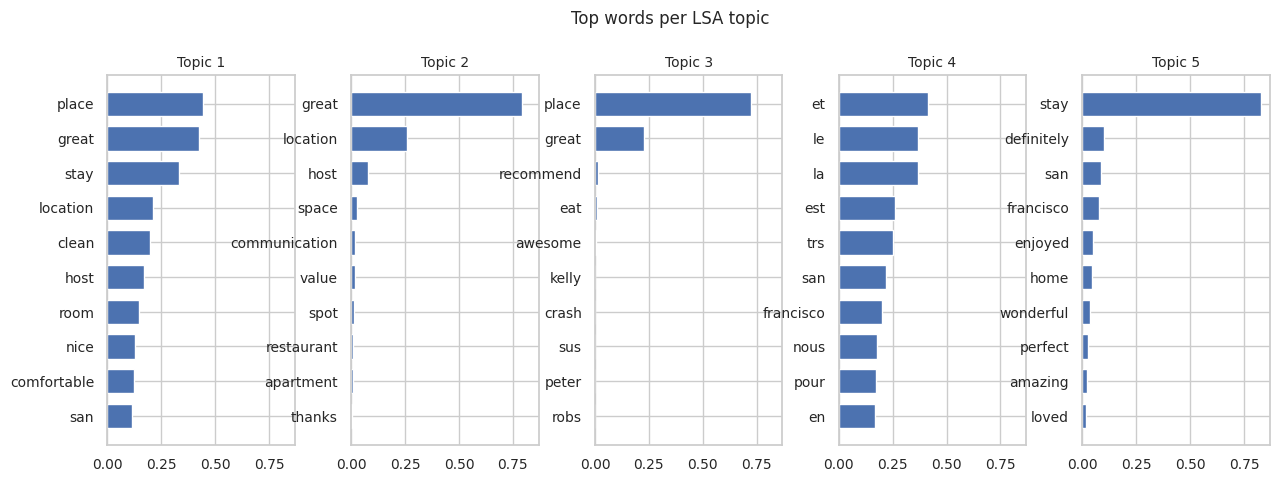

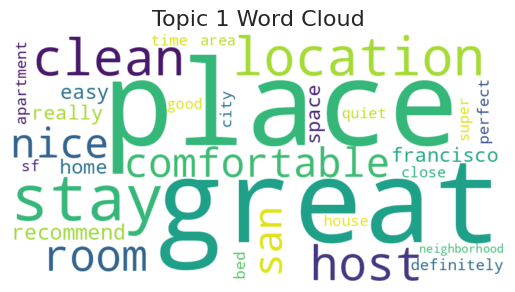

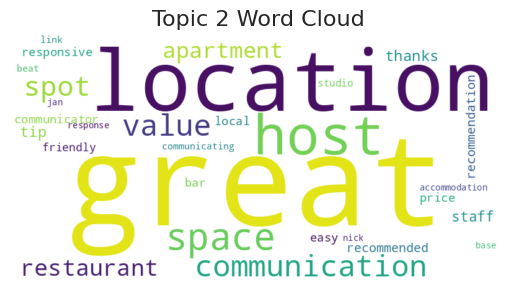

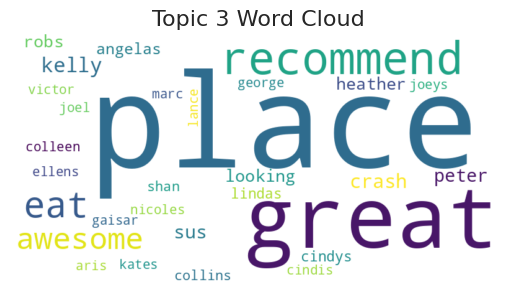

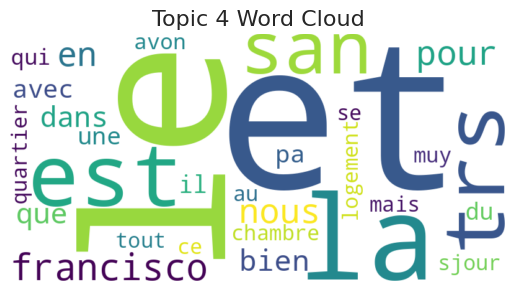

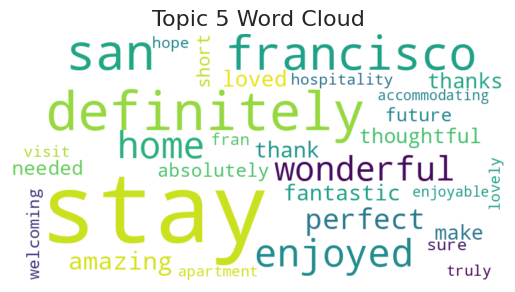

In [ ]:
# LSA Topic Plots
plot_top_words(lsa_model, terms, n_top_words=10, title='Top words per LSA topic')
plot_word_clouds(lsa_model, terms)

# **Calendar Dataset:**

## **Import Libraries:**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## **Load Dataset and Initial Exploration:**

In [ ]:
calendar_df = pd.read_csv(calendar_url, compression='gzip')

In [ ]:
calendar_df.head()

listing_id        date available  price  adjusted_price  minimum_nights  \
0         958  2025-09-01         f    NaN             NaN               2   
1         958  2025-09-02         f    NaN             NaN               2   
2         958  2025-09-03         f    NaN             NaN               2   
3         958  2025-09-04         f    NaN             NaN               2   
4         958  2025-09-05         f    NaN             NaN               2   

   maximum_nights  
0            1125  
1            1125  
2            1125  
3            1125  
4            1125

In [ ]:
calendar_df.shape

(2839700, 7)

The dataset contains 2,839,700 rows and 7 columns, representing Airbnb listing calendar data for San Francisco. Each row corresponds to a specific listing’s availability and pricing information on a particular date.

In [ ]:
print(calendar_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2839700 entries, 0 to 2839699
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   listing_id      int64  
 1   date            object 
 2   available       object 
 3   price           float64
 4   adjusted_price  float64
 5   minimum_nights  int64  
 6   maximum_nights  int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 151.7+ MB
None


In [ ]:
print(calendar_df.describe(include="all"))

          listing_id        date available  price  adjusted_price  \
count   2.839700e+06     2839700   2839700    0.0             0.0   
unique           NaN         365         2    NaN             NaN   
top              NaN  2026-08-31         t    NaN             NaN   
freq             NaN        7780   1476970    NaN             NaN   
mean    5.423931e+17         NaN       NaN    NaN             NaN   
std     5.626450e+17         NaN       NaN    NaN             NaN   
min     9.580000e+02         NaN       NaN    NaN             NaN   
25%     2.826221e+07         NaN       NaN    NaN             NaN   
50%     5.743371e+17         NaN       NaN    NaN             NaN   
75%     1.074843e+18         NaN       NaN    NaN             NaN   
max     1.499678e+18         NaN       NaN    NaN             NaN   

        minimum_nights  maximum_nights  
count     2.839700e+06    2.839700e+06  
unique             NaN             NaN  
top                NaN             NaN  
freq   

Total unique listings: 7,780

Each listing appears multiple times (one per date) in the dataset.

## **Missing Values and Data Types:**

In [ ]:
print(calendar_df.isna().sum())

listing_id              0
date                    0
available               0
price             2839700
adjusted_price    2839700
minimum_nights          0
maximum_nights          0
dtype: int64


In [ ]:
print(calendar_df.dtypes)

listing_id          int64
date               object
available          object
price             float64
adjusted_price    float64
minimum_nights      int64
maximum_nights      int64
dtype: object


## **Value Counts for Availability:**

In [ ]:
print(calendar_df['available'].value_counts())

available
t    1476970
f    1362730
Name: count, dtype: int64


## **Convert and Process Columns:**

In [ ]:
calendar_df['available'] = calendar_df['available'].map({'t': True, 'f': False})

In [ ]:
availability_rate = calendar_df['available'].mean()

## **Check Date Range:**

In [ ]:
calendar_df['date'] = pd.to_datetime(calendar_df['date'])

In [ ]:
print(calendar_df['date'].min(), "to", calendar_df['date'].max())

2025-09-01 00:00:00 to 2026-08-31 00:00:00


The dataset spans from September 1, 2025 to August 31, 2026, covering a full year of calendar data.

## **Calculate Availability Rate:**

In [ ]:
availability_over_time = calendar_df.groupby('date')['available'].mean()

## **Availability Over Time:**

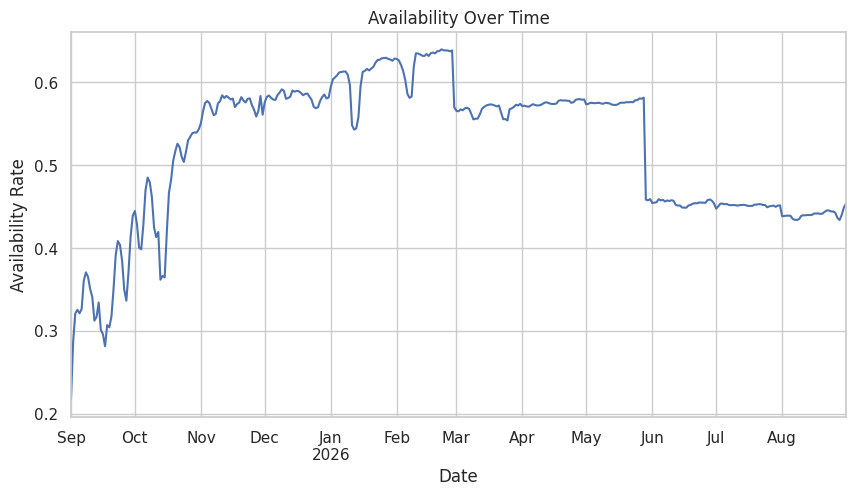

In [ ]:
plt.figure(figsize=(10,5))
availability_over_time.plot(title='Availability Over Time')
plt.xlabel('Date')
plt.ylabel('Availability Rate')
plt.show()

The availability rate is approximately 52 percent, meaning that on average, half of all listings are available at any given time.

The availability over time plot shows fluctuations that can indicate seasonal demand patterns.

In [ ]:
calendar_df['price'] = pd.to_numeric(calendar_df['price'], errors='coerce')
calendar_df['adjusted_price'] = pd.to_numeric(calendar_df['adjusted_price'], errors='coerce')

## **Price Distribution:**

In [ ]:
missing_price = calendar_df['price'].isna().mean()

In [ ]:
if calendar_df['price'].notna().sum() > 0:
    plt.figure(figsize=(8,5))
    plt.hist(calendar_df['price'].dropna(), bins=30)
    plt.title('Price Distribution')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.show()

The price and adjusted_price columns contain 100 percent missing values, as indicated by a missing ratio of 1.0.

This prevents any valid analysis of price distribution or trends.

Therefore, the dataset either lacks pricing information or requires merging with another data source to fill these fields.

## **Minimum Nights Distribution:**

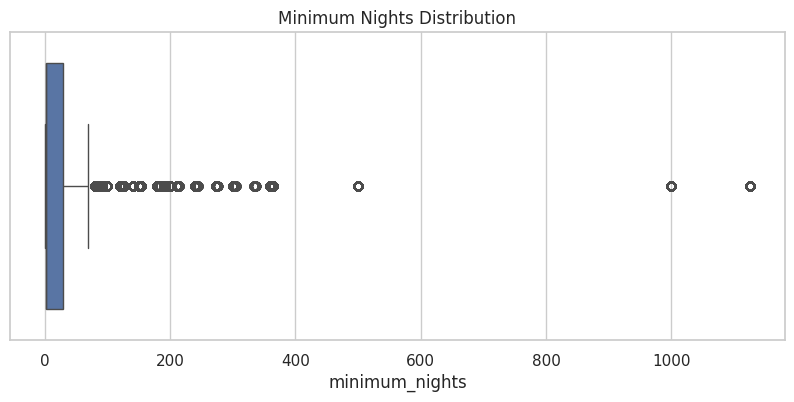

In [ ]:
plt.figure(figsize=(10,4))
sns.boxplot(x=calendar_df['minimum_nights'])
plt.title('Minimum Nights Distribution')
plt.show()

## **Maximum Nights Distribution:**

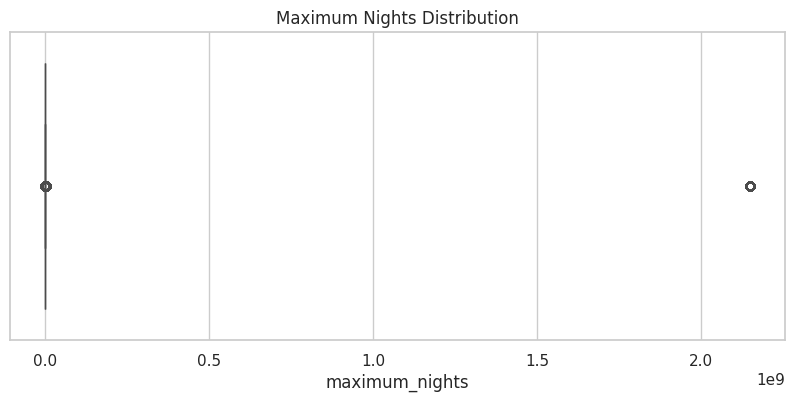

In [ ]:
plt.figure(figsize=(10,4))
sns.boxplot(x=calendar_df['maximum_nights'])
plt.title('Maximum Nights Distribution')
plt.show()

The minimum_nights variable shows a wide distribution, mostly around 2 to 30 nights, with some listings requiring very long stays (up to 1,125 nights).

The maximum_nights variable has extremely large values (up to over 2 billion), likely due to default limits or data errors.

## **Correlation Matrix:**

In [ ]:
num_df = calendar_df.select_dtypes(include='number')

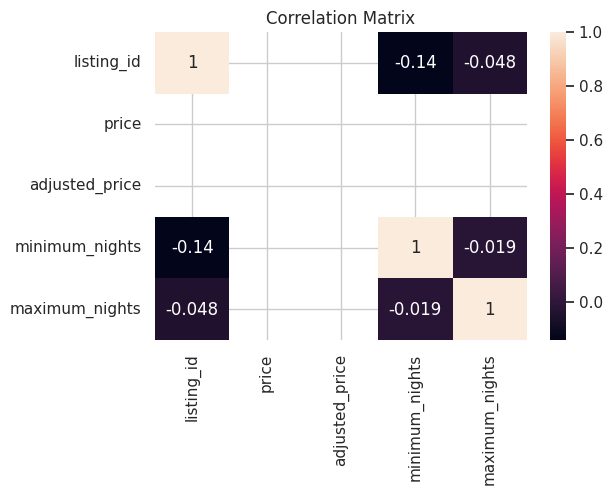

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(num_df.corr(), annot=True)
plt.title('Correlation Matrix')
plt.show()

The correlation matrix reveals weak relationships among numeric variables.

No strong linear correlation exists between stay lengths (minimum or maximum nights) and other numeric fields, which suggests these are independent listing characteristics.

## **Summary of Findings:**

In [ ]:
summary = {
    'total_rows': len(calendar_df),
    'unique_listings': calendar_df['listing_id'].nunique(),
    'availability_rate': availability_rate,
    'price_missing_ratio': missing_price,
    'date_range': (calendar_df['date'].min(), calendar_df['date'].max())
}

print("\nSummary:")
for k, v in summary.items():
    print(f"{k}: {v}")


Summary:
total_rows: 2839700
unique_listings: 7780
availability_rate: 0.5201148008592457
price_missing_ratio: 1.0
date_range: (Timestamp('2025-09-01 00:00:00'), Timestamp('2026-08-31 00:00:00'))


# **Final Summary and Insights:**

This exploratory analysis provided an understanding of the Airbnb San Francisco dataset, using the listing, calendar, and review data to uncover key patterns and relationships.

1. Data Preparation and Cleaning:

    * All datasets were loaded, inspected, and cleaned for completeness and consistency.
    * Columns with no analytical value and empty placeholders were removed.
    * Missing values were handled strategically: categorical fields filled with “Unknown,” text fields with “Not provided,” and numeric variables with median imputation to preserve distribution.
    * Price values were cleaned and converted to numeric format, and date fields standardized for time-based analysis.

2. Feature Correlation and Reduction:

    * Correlation analysis revealed strong multicollinearity among night-rule variables and review sub-scores.
    * Only representative features such as minimum_nights and review_scores_rating were retained to simplify future modeling.
    * Strong positive correlations were found among review-related attributes and between occupancy metrics and review ratings.

3. Price and Availability Analysis:

    * Price distribution was right-skewed with extreme outliers removed for better interpretability.
    * High variation in prices was observed across neighborhoods and property types, suggesting location and accommodation style as major drivers of price.
    * Approximately half of all listings remain available at any given time, indicating a balanced market with seasonal fluctuations in demand.

4. Host and Property Insights;

    * Superhosts generally command higher prices, likely reflecting greater trust and service quality.
    * Longer host tenure correlates modestly with higher prices, suggesting experience contributes to pricing strategy.
    * Listings with more amenities and higher occupancy show positive associations with price, confirming that value-added features attract premium rates.

5. Review Text Analysis and Topic Modeling:

    * Review comments were cleaned, tokenized, and lemmatized to remove noise and standardize language.
    * Text vectorization (BoW, TF-IDF) enabled deeper insights through LDA, NMF, and LSA topic models.
    * Common themes across models highlight cleanliness, location, comfort, and host friendliness as recurring positive experiences.

6. Calendar Insights:

    * The calendar data spans one full year (Sept 2025–Aug 2026) and reflects daily listing availability.
    * Although pricing data was missing from the calendar dataset, minimum and maximum stay durations were analyzed.
    * Minimum stays typically range between 2 and 30 nights, while maximum values were highly inconsistent, likely due to data entry defaults or system limits.

**Conclusion:**

* The San Francisco Airbnb market displays clear relationships between price, amenities, location, and host quality.
* Strong cleaning and feature selection have created a refined dataset suitable for further predictive modeling.
* Text-based sentiment and topic modeling add valuable qualitative context to quantitative trends, enhancing the interpretability of guest preferences.

# **Feature Engineering**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd

PROJECT_DIR = "/content/drive/MyDrive/AIProject"   # Folder must exist in Drive

def save_df_to_drive(df: pd.DataFrame, filename: str, file_format: str = "parquet"):

    file_format = file_format.lower().strip()

    # Ensure correct extension
    if "." in filename:
        # if user passed an extension, strip it and re-append based on format
        filename = os.path.splitext(filename)[0]

    if file_format == "csv":
        filename = f"{filename}.csv"
    elif file_format in ("parquet", "pq"):
        filename = f"{filename}.parquet"
    elif file_format in ("excel", "xlsx"):
        filename = f"{filename}.xlsx"
    else:
        raise ValueError("Unsupported format. Use 'csv', 'parquet', or 'excel'.")

    full_path = os.path.join(PROJECT_DIR, filename)

    # Save according to format
    if file_format == "csv":
        df.to_csv(full_path, index=False)
    elif file_format in ("parquet", "pq"):
        df.to_parquet(full_path, index=False)
    elif file_format in ("excel", "xlsx"):
        df.to_excel(full_path, index=False)

    print(f"Saved DataFrame to: {full_path}")
    return full_path


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# cleansed_listings = cleansed_listings.rename(columns={'id': 'listing_id'})

# save_df_to_drive(cleansed_listings, "after_eda_listing", "csv")
# save_df_to_drive(reviews_df, "after_eda_reviews", "parquet")

reviews_df = pd.read_parquet(f"{PROJECT_DIR}/after_eda_reviews.parquet")
print(reviews_df.shape)
cleansed_listings = pd.read_csv(f"{PROJECT_DIR}/after_eda_listing.csv")
print(cleansed_listings.shape)

(410017, 9)
(5737, 66)


In [ ]:

!pip install langdetect

from langdetect import detect, DetectorFactory
import pandas as pd

from tqdm.auto import tqdm

batch_size = 2000  # tune based on your data size and patience

# Initialize the column
reviews_df['lang'] = 'unknown'

n = len(reviews_df)

from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0  # reproducible

def detect_lang(text):
    if not isinstance(text, str) or text.strip() == "":
        return "unknown"
    try:
        return detect(text)
    except:
        return "unknown"

for start in tqdm(range(0, n, batch_size)):

    end = min(start + batch_size, n)
    print(start, end)
    # Work on this slice
    chunk = reviews_df.loc[start:end - 1, 'cleaned_reviews']

    # Apply langdetect only on this chunk
    langs = chunk.apply(detect_lang)

    # Assign back to the same rows
    reviews_df.loc[start:end - 1, 'lang'] = langs

# Ensure text is string
reviews_df['cleaned_reviews'] = reviews_df['cleaned_reviews'].fillna("").astype(str)

# Keep only English
valid_df = reviews_df[reviews_df['lang'] == 'en'].copy()

save_df_to_drive(valid_df, "only_english_reviews", "parquet")



  0%|          | 0/206 [00:00<?, ?it/s]

0 2000
2000 4000
4000 6000
6000 8000
8000 10000
10000 12000
12000 14000
14000 16000
16000 18000
18000 20000
20000 22000
22000 24000
24000 26000
26000 28000
28000 30000
30000 32000
32000 34000
34000 36000
36000 38000
38000 40000
40000 42000
42000 44000
44000 46000
46000 48000
48000 50000
50000 52000
52000 54000
54000 56000
56000 58000
58000 60000
60000 62000
62000 64000
64000 66000
66000 68000
68000 70000
70000 72000
72000 74000
74000 76000
76000 78000
78000 80000
80000 82000
82000 84000
84000 86000
86000 88000
88000 90000
90000 92000
92000 94000
94000 96000
96000 98000
98000 100000
100000 102000
102000 104000
104000 106000
106000 108000
108000 110000
110000 112000
112000 114000
114000 116000
116000 118000
118000 120000
120000 122000
122000 124000
124000 126000
126000 128000
128000 130000
130000 132000
132000 134000
134000 136000
136000 138000
138000 140000
140000 142000
142000 144000
144000 146000
146000 148000
148000 150000
150000 152000
152000 154000
154000 156000
156000 158000
15800

'/content/drive/MyDrive/AIProject/only_english_reviews.parquet'

## Add sentiment scores (VADER)

In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.auto import tqdm

nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()
tqdm.pandas()

def vader_comp(text):
    if not isinstance(text, str) or text.strip() == "":
        return 0.0
    return sia.polarity_scores(text)['compound']

valid_df['vader_compound'] = valid_df['cleaned_reviews'].progress_apply(vader_comp)

save_df_to_drive(valid_df, "after_vader_compound", "parquet")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


  0%|          | 0/366885 [00:00<?, ?it/s]

Saved DataFrame to: /content/drive/MyDrive/AIProject/after_vader_compound.parquet


'/content/drive/MyDrive/AIProject/after_vader_compound.parquet'

## Add emotion probabilities (DistilRoBERTa emotion model)

In [ ]:
from transformers import pipeline
import numpy as np

emotion_model = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    top_k=None,        # get full distribution
    truncation=True
)

texts = valid_df['cleaned_reviews'].tolist()   # list[str], not a Series
batch_size = 10000

all_results = []
for i in tqdm(range(0, len(texts), batch_size)):
    print("Processing ", i + batch_size, " of ", len(texts))
    batch_texts = texts[i:i+batch_size]        # this is list[str]
    batch_out = emotion_model(batch_texts)     # OK
    all_results.extend(batch_out)

Device set to use cuda:0


  0%|          | 0/37 [00:00<?, ?it/s]

Processing  10000  of  366885
Processing  20000  of  366885
Processing  30000  of  366885
Processing  40000  of  366885
Processing  50000  of  366885
Processing  60000  of  366885
Processing  70000  of  366885
Processing  80000  of  366885
Processing  90000  of  366885
Processing  100000  of  366885


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Processing  110000  of  366885
Processing  120000  of  366885
Processing  130000  of  366885
Processing  140000  of  366885
Processing  150000  of  366885
Processing  160000  of  366885
Processing  170000  of  366885
Processing  180000  of  366885
Processing  190000  of  366885
Processing  200000  of  366885
Processing  210000  of  366885
Processing  220000  of  366885
Processing  230000  of  366885
Processing  240000  of  366885
Processing  250000  of  366885
Processing  260000  of  366885
Processing  270000  of  366885
Processing  280000  of  366885
Processing  290000  of  366885
Processing  300000  of  366885
Processing  310000  of  366885
Processing  320000  of  366885
Processing  330000  of  366885
Processing  340000  of  366885
Processing  350000  of  366885
Processing  360000  of  366885
Processing  370000  of  366885


## Convert model outputs to columns

In [ ]:
# Get full set of labels
all_labels = sorted({e['label'] for r in all_results for e in r})
label2idx = {lab: i for i, lab in enumerate(all_labels)}

emotion_arr = np.zeros((len(valid_df), len(all_labels)), dtype=float)
dominants = []

for idx, res in enumerate(all_results):
    vec = np.zeros(len(all_labels))
    best_label = None
    best_score = -1
    for e in res:
        lab = e['label']
        score = e['score']
        vec[label2idx[lab]] = score
        if score > best_score:
            best_score = score
            best_label = lab
    emotion_arr[idx, :] = vec
    dominants.append(best_label)

# Attach to df
for i, lab in enumerate(all_labels):
    colname = f"emo_{lab}"
    valid_df[colname] = emotion_arr[:, i]

valid_df['dominant_emotion_review'] = dominants

emo_cols = [f"emo_{lab}" for lab in all_labels]

save_df_to_drive(valid_df, "after_emotional_probabilities", "parquet")



Saved DataFrame to: /content/drive/MyDrive/AIProject/after_emotional_probabilities.parquet


'/content/drive/MyDrive/AIProject/after_emotional_probabilities.parquet'

## Aggregate to listing-level emotional profile

In [ ]:
valid_df = valid_df.loc[:, ~valid_df.columns.duplicated()].copy()

def entropy(p):
    p = np.clip(p, 1e-9, 1.0)
    p = p / p.sum()
    return -(p * np.log(p)).sum()

# Aggregate sentiment + emotion
agg_dict = {
    'vader_compound': ['mean', 'var', 'count']
}
for col in emo_cols:
    agg_dict[col] = 'mean'

listing_emotions = valid_df.groupby('listing_id').agg(agg_dict)
listing_emotions.columns = ['_'.join(c).strip('_') for c in listing_emotions.columns]
listing_emotions = listing_emotions.reset_index()

# Rename for clarity
listing_emotions = listing_emotions.rename(columns={
    'vader_compound_mean': 'avg_sentiment',
    'vader_compound_var': 'sentiment_variance',
    'vader_compound_count': 'n_reviews'
})

# Compute entropy & dominant emotion at listing level
emo_mean_cols = [c for c in listing_emotions.columns if c.startswith('emo_')]

emo_mean_matrix = listing_emotions[emo_mean_cols].values
listing_emotions['emotion_entropy'] = [entropy(row) for row in emo_mean_matrix]

# Dominant emotion = argmax of mean probs
idx_max = emo_mean_matrix.argmax(axis=1)
idx2label = {i: col.replace('emo_', '') for i, col in enumerate(emo_mean_cols)}
listing_emotions['dominant_emotion_listing'] = [
    idx2label[i] for i in idx_max
]

save_df_to_drive(listing_emotions, "after_grouping_listings", "parquet")


Saved DataFrame to: /content/drive/MyDrive/AIProject/after_grouping_listings.parquet


'/content/drive/MyDrive/AIProject/after_grouping_listings.parquet'

In [ ]:
listing_cols = [
    'listing_id', 'name',
    'neighbourhood_cleansed', 'latitude', 'longitude',
    'property_type', 'room_type', 'accommodates',
    'bathrooms', 'bathrooms_text', 'bedrooms', 'beds',
    'price', 'minimum_nights', 'maximum_nights',
    'has_availability', 'availability_30', 'availability_60',
    'availability_90', 'availability_365',
    'estimated_occupancy_l365d', 'estimated_revenue_l365d',
    'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
    'reviews_per_month', 'first_review', 'last_review',
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_value',
    'host_id', 'host_since', 'host_location', 'host_about',
    'host_response_time', 'host_response_rate', 'host_acceptance_rate',
    'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
    'host_identity_verified', 'amenities', #'amenity_count',
    'instant_bookable'  # from our earlier aggregation
]

# Pick one row per listing
listing_base = cleansed_listings[listing_cols].drop_duplicates(subset=['listing_id']).copy()
listing_features = listing_base.merge(
    listing_emotions,
    on='listing_id',
    how='left'
)

save_df_to_drive(listing_features, "final_result_w_listings", "parquet")

Saved DataFrame to: /content/drive/MyDrive/AIProject/final_result_w_listings.parquet


'/content/drive/MyDrive/AIProject/final_result_w_listings.parquet'

In [ ]:
listing_features.shape

# listing_features[['listing_id', 'avg_sentiment', 'sentiment_variance', 'n_reviews',
#        'emo_anger_mean', 'emo_disgust_mean', 'emo_fear_mean', 'emo_joy_mean',
#        'emo_neutral_mean', 'emo_sadness_mean', 'emo_surprise_mean',
#        'emotion_entropy', 'dominant_emotion_listing']]

(5737, 56)

In [ ]:
listing_features['dominant_emotion_listing'].value_counts()

dominant_emotion_listing
joy_mean    97
Name: count, dtype: int64